## Mathmatical Preamble

In [630]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [631]:
def f(x):
  return 3*x**2 - 4*x + 5

In [632]:
f(3.0)

20.0

In [633]:
xs = np.arange(-5,5,.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

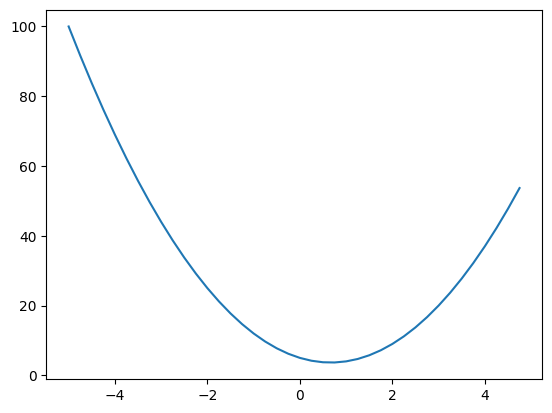

In [634]:
plt.plot(xs,ys)

In [635]:
# el valor calculado de la derivada es 14
h = 0.000000001
x = 3.0
(f(x + h) - f(x))/h

14.000001158365194

In [636]:
# el valor calculado de la derivada es -22
h = 0.000000001
x = -3.0
(f(x + h) - f(x))/h

-22.000001820288162

In [637]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [638]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [639]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [640]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1',d1)
print('d2',d2)
print('slope',(d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


# Building Micrograd


## The Core Object of Micrograd: Value

In [641]:
class Value:
  def __init__(self, data, _childs=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # By default we assume that every value has no effect over the output
    self._prev = set(_childs)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    return out

In [642]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a*b; d.label = 'd'
e = d + c; e.label = 'e' # a.__mul__(b).__add__(c)
f = Value(-2.0, label='f')
L = f * e; L.label = 'L'
L

Value(data=-8.0)

In [643]:
d._prev

{Value(data=-3.0), Value(data=2.0)}

In [644]:
d._op

'*'

In [645]:
from graphviz import Digraph

def trace(root):
  # Builds a set of all nodes and edges of a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) # LR: left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of an operation then create a node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1,n2 in edges:
    # connect n1 to the operation node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

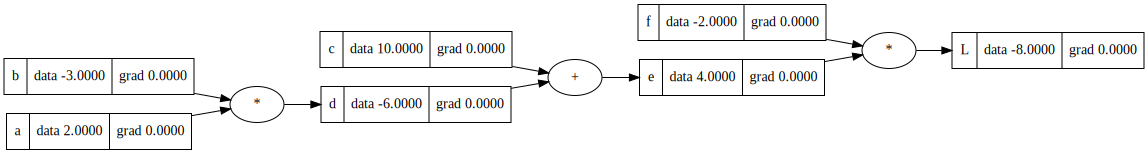

In [646]:
draw_dot(L)

### Now lets play with some neurons
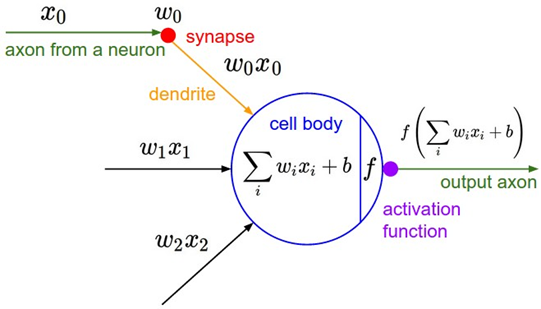

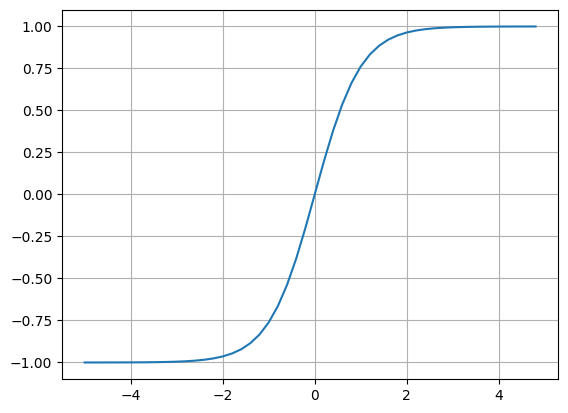

In [647]:
# tanh is a commonly activation function for neurons
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));plt.grid()

In [648]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

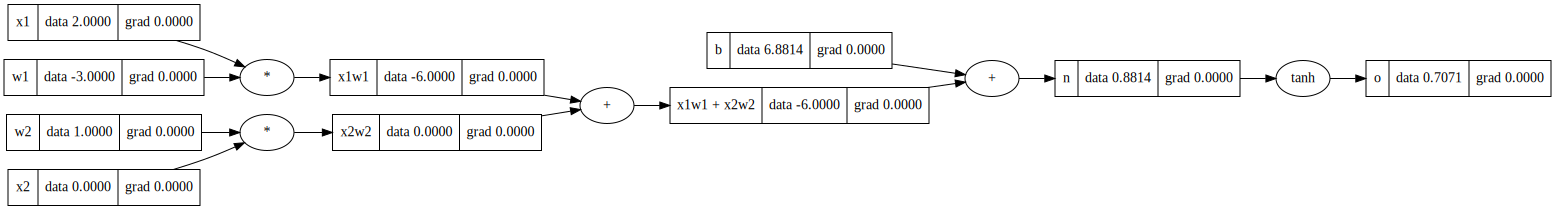

In [649]:
draw_dot(o)

## Backpropagation

Backpropagation is just a recursive application of the chain rule backwards through the computation graph.

In [650]:
class Value:
  def __init__(self, data, _childs=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # By default we assume that every value has no effect over the output
    self._backward = lambda: None
    self._prev = set(_childs)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh') # Las operaciones sobre un mismo nodo tan solo tienen un hijo,
                                     # que es el propio nodo antes de aplicarle la operación

    def _backward():
      self.grad = (1 - t**2) * out.grad

    out._backward = _backward

    return out

In [651]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [652]:
o.grad = 1 # Inicializamos el caso base con gradiente uno para poder llevar a cabo la propagación
# recordar que por defecto los valores se inicializan con gradiente 0

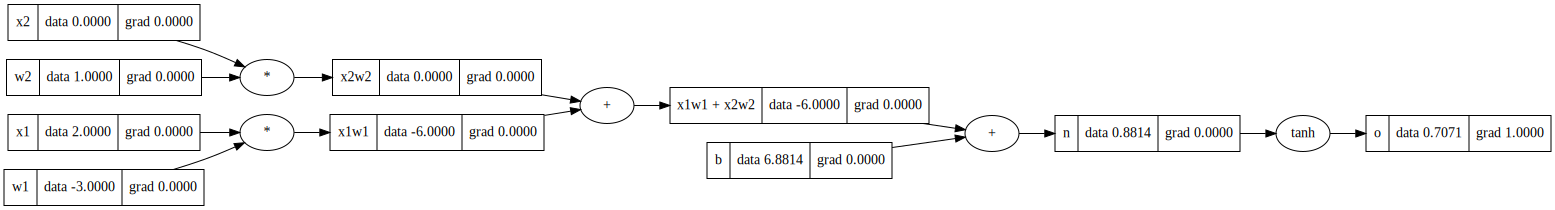

In [653]:
draw_dot(o)

### Implementing Backward Function for a Whole Graph

First of all, what we want is to go backward through that expression what just means that we never want to call
 ._backward for any node before we've done everything after it, we have to get all it's dependencies before we can continue backpropagation.

This ordering of graph can be achieved with **topological sort**, what is a lay out of a graph where or the edges go only in one way, ie. from left to right.

In [654]:
# Function that guarantees that you are not going to be in the list until all
# your children are already in the list
topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

In [655]:
# Function that backpropagates the gradient through all the graph
def backward_graph(topo):
  for node in reversed(topo):
    node._backward()

In [656]:
backward_graph(topo)


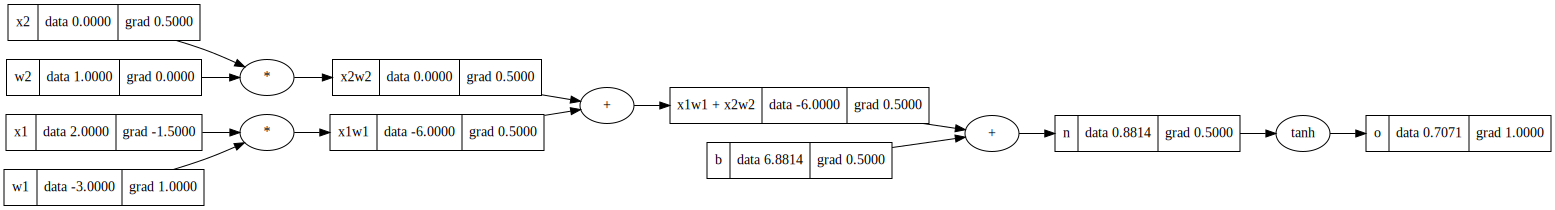

In [657]:
draw_dot(o)

In [658]:
class Value:
  def __init__(self, data, _childs=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # By default we assume that every value has no effect over the output
    self._backward = lambda: None
    self._prev = set(_childs)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad

    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad

    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    def backward_graph(topo):
      for node in reversed(topo):
        node._backward()

    self.grad = 1.0
    build_topo(self)
    backward_graph(topo)

In [659]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [660]:
o.backward()

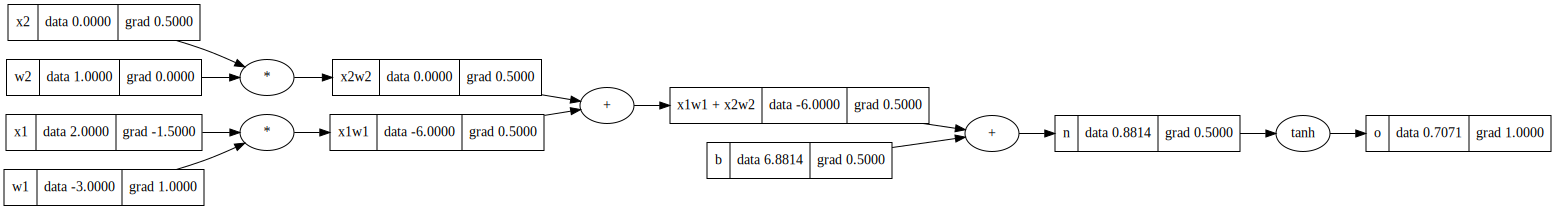

In [661]:
draw_dot(o)

We have a bug related with those cases in wich the same node is called multiple times, as in the following example.

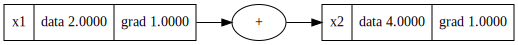

In [662]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
o = x1 + x1; o.label = 'x2'
o.backward()
# Real gradient must be 2
draw_dot(o)

In [663]:
class Value:
  def __init__(self, data, _childs=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # By default we assume that every value has no effect over the output
    self._backward = lambda: None
    self._prev = set(_childs)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
        self.grad += 1.0 * out.grad # The problem we were having was that every time a node was accessed more than
        other.grad += 1.0 * out.grad # once the value of the gradient was overwritten. Now we add it to the
                                     # previously calculated in other accesses.
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    def backward_graph(topo):
      for node in reversed(topo):
        node._backward()

    self.grad = 1.0
    build_topo(self)
    backward_graph(topo)

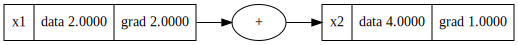

In [664]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
o = x1 + x1; o.label = 'x2'
o.backward()
# Real gradient must be 2
draw_dot(o)

## Tweaking Value Class

In [665]:
class Value:
  def __init__(self, data, _childs=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # By default we assume that every value has no effect over the output
    self._backward = lambda: None
    self._prev = set(_childs)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other, label=f'{other}') # So we can directly apperate between Values and numbers
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
        self.grad += 1.0 * out.grad # The problem we were having was that every time a node was accessed more than
        other.grad += 1.0 * out.grad # once the value of the gradient was overwritten. Now we add it to the
                                     # previously calculated in other accesses.
    out._backward = _backward

    return out

  def __radd__(self,other): # other + self
    return self + other

  def __neg__(self): # - self
    return self * (-1)

  def __sub__(self, other): # self - other
    return self + (- other)

  def __rsub__(self, other): # other - self
    other = other if isinstance(other, Value) else Value(other, label=f'{other}') # So we can directly apperate between Values and numbers

    return other - self

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other, label=f'{other}')
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward

    return out

  def __rmul__(self,other): # other * self
    return self * other

  def __pow__(self, other): # self ** other
    other = other if isinstance(other, Value) else Value(other, label=f'{other}')
    out = Value(self.data ** other.data, (self,other), f'{self.label}**{other.label}')

    def _backward():
      self.grad += other.data * (self.data ** (other.data-1)) * out.grad
      if self.data == 0:
        other.grad = 0
      elif self.data < 0:
        other.grad += (-1) * (self.data ** (other.data)) * math.log((-1) * self.data) * out.grad
      else:
        other.grad += (self.data ** (other.data)) * math.log(self.data) * out.grad

    out._backward = _backward

    return out

  def __truediv__(self,other): # self/other
    return self * other**-1

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad

    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad

    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        if isinstance(v, Value):
          for child in v._prev:
            build_topo(child)
        topo.append(v)

    def backward_graph(topo):
      for node in reversed(topo):
        node._backward()

    self.grad = 1.0
    build_topo(self)
    backward_graph(topo)

In [666]:
# With the following code we used to get an error
a = Value(2.0); a.label = 'a'
b = Value(2.0); b.label = 'b'
a + 2
a * 1 # a.__mul__(1)

Value(data=2.0)

In [667]:
1 + a # When python tries this opperation and fails, it then checks if Value has
      # the __rmul__ method defined, in that case it will use it to make the opperation

Value(data=3.0)

In [668]:
#a / b
#a * (1 / b)
c = a ** 2; c.label = 'c' # we have to implement x**k operation
d = c / a
d

Value(data=2.0)

In [669]:
d.backward()

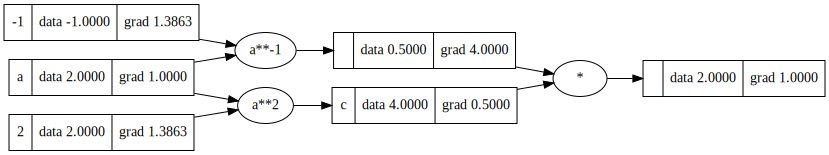

In [670]:
draw_dot(d)

In [671]:
a = Value(2.0); a.label = 'a'

a - 2

Value(data=0.0)

In [672]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [673]:
o.backward()

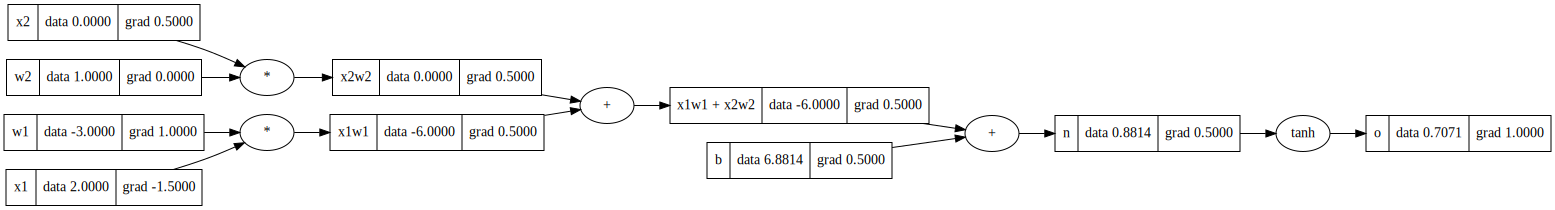

In [674]:
draw_dot(o)

In [675]:
# inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1,w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# --------
e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
# --------
o.label = 'o'
o.backward()

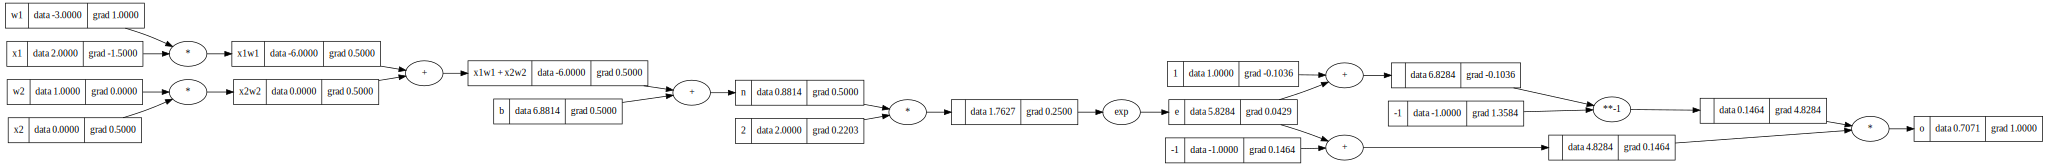

In [676]:
draw_dot(o)

## Now With Pytorch

In [677]:
import torch

In [678]:
# Pytorch assumes that this kind of scalar tensors do not need gradient, so you have to
# explicitly say it. This is because in general we would not want to compute gradients for leaf nodes,
# and this is PyTorch trying to be efficient in the most common cases.
x1 = torch.tensor([2.0]).double();                        x1.requires_grad = True
w1 = torch.tensor([-3.0]).double();                       w1.requires_grad = True
x2 = torch.tensor([0.0]).double();                        x2.requires_grad = True
w2 = torch.tensor([1.0]).double();                        w2.requires_grad = True
b = torch.tensor([6.8813735870195432]).double();          b.requires_grad = True
n = x1*w1 + x2*w2 + b;
o = torch.tanh(n);

print(o.data.item())
o.backward()

print('--------')
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

0.7071066904050358
--------
-1.5000003851533106
1.0000002567688737
0.5000001283844369
0.0


# Building a Neural Network

## The Neuron Class

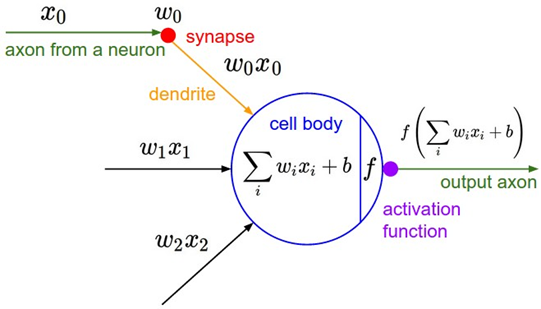


In [679]:
import random

In [680]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)  # zip creates a list of tuples [(w1,x1),(w2,x2),...]
    out = act.tanh()
    return out

In [681]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=0.9814084461430432)

## Layers of Neurons

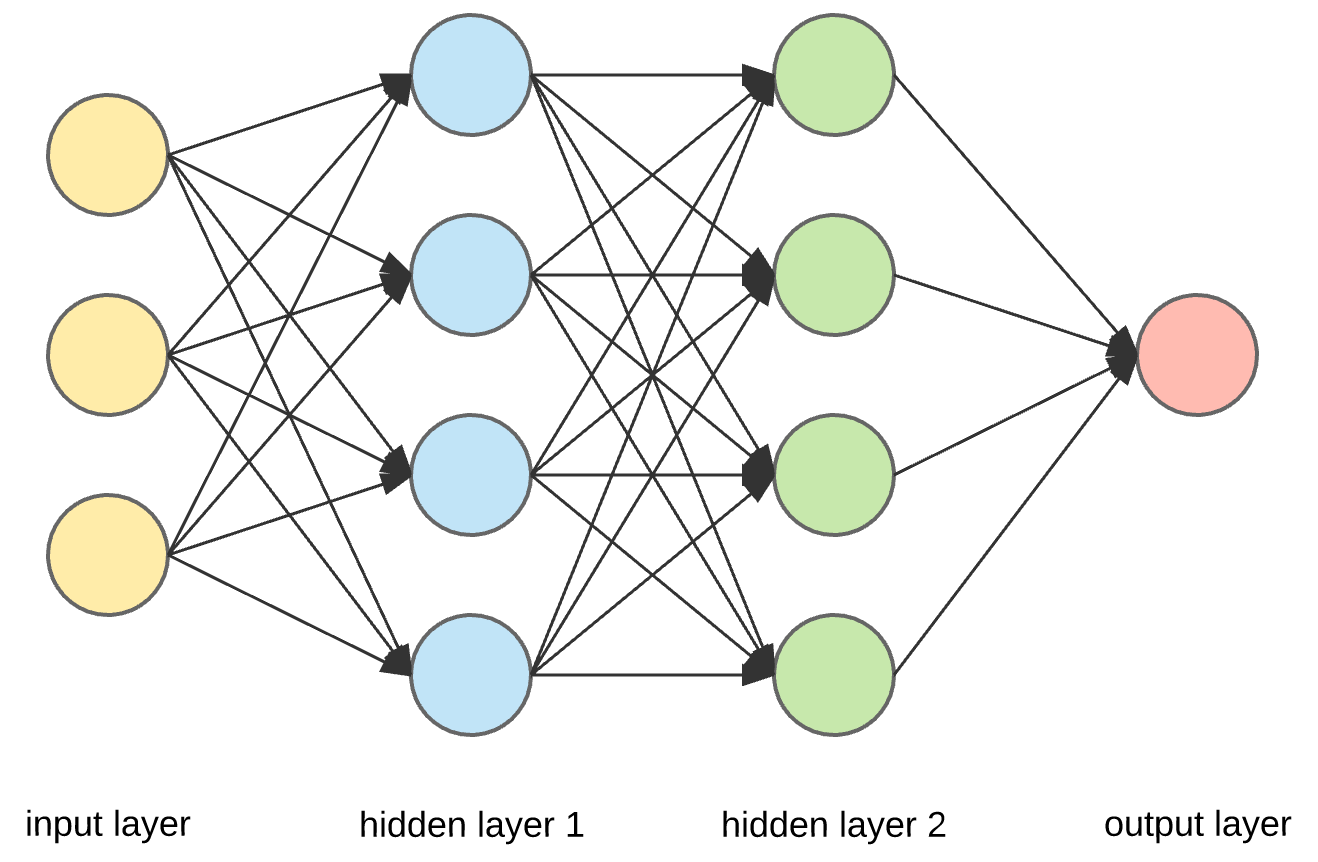

In [682]:
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs


In [683]:
x = [2.0, 3.0]
l = Layer(2,3)
l(x)

[Value(data=-0.2052649956412981),
 Value(data=-0.783891422501033),
 Value(data=-0.9918991741733194)]

## The Multi-Layer Perceptron

In [684]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] # or len(sz) - 1

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [685]:
x = [2.0, 3.0, -1.0]
p = MLP(3,[4,4,1])
p(x)

Value(data=-0.5964885169682468)

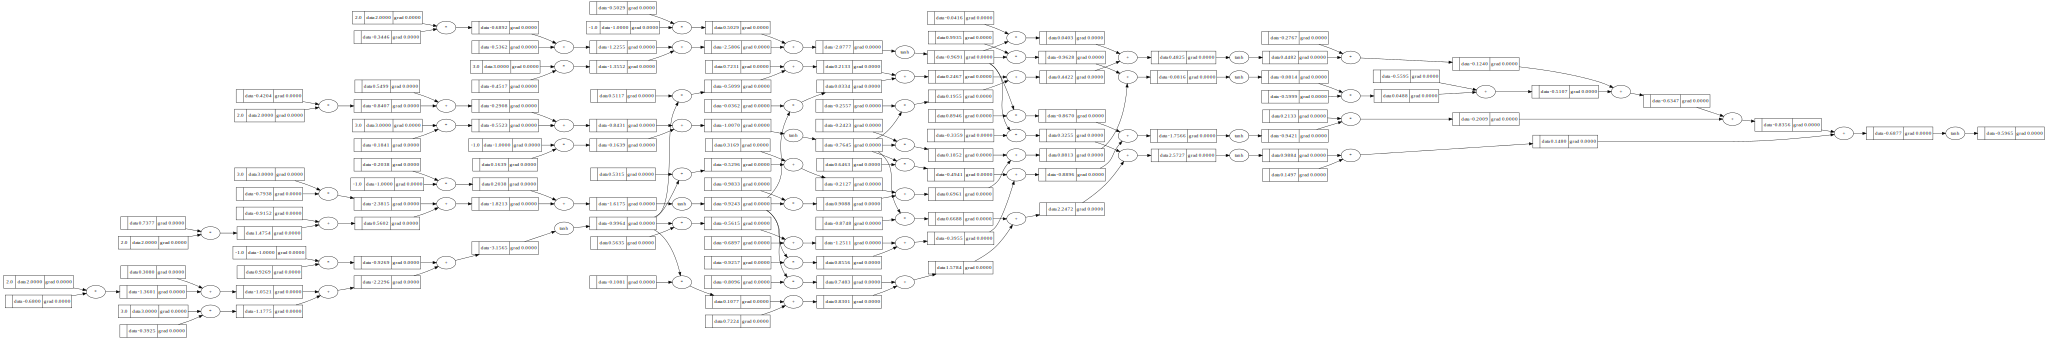

In [686]:
draw_dot(p(x))

## The Loss Function


In [687]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [688]:
ypred = [p(x) for x in xs]
ypred

[Value(data=-0.5964885169682468),
 Value(data=-0.23393611282187363),
 Value(data=-0.7327056788198092),
 Value(data=-0.5361463358207398)]

How do we make the NN and how do we tune the weights to better predict the desired target?

The trick used in DL to achive this is to calculate a single number that somehow measures the total performance of your NN and we call this number the **loss**. The goal to optimize the performance of the NN will be to minimize that loss.

In [689]:
loss = (sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred)))
loss

Value(data=5.566821283240597)

In [690]:
loss.backward()

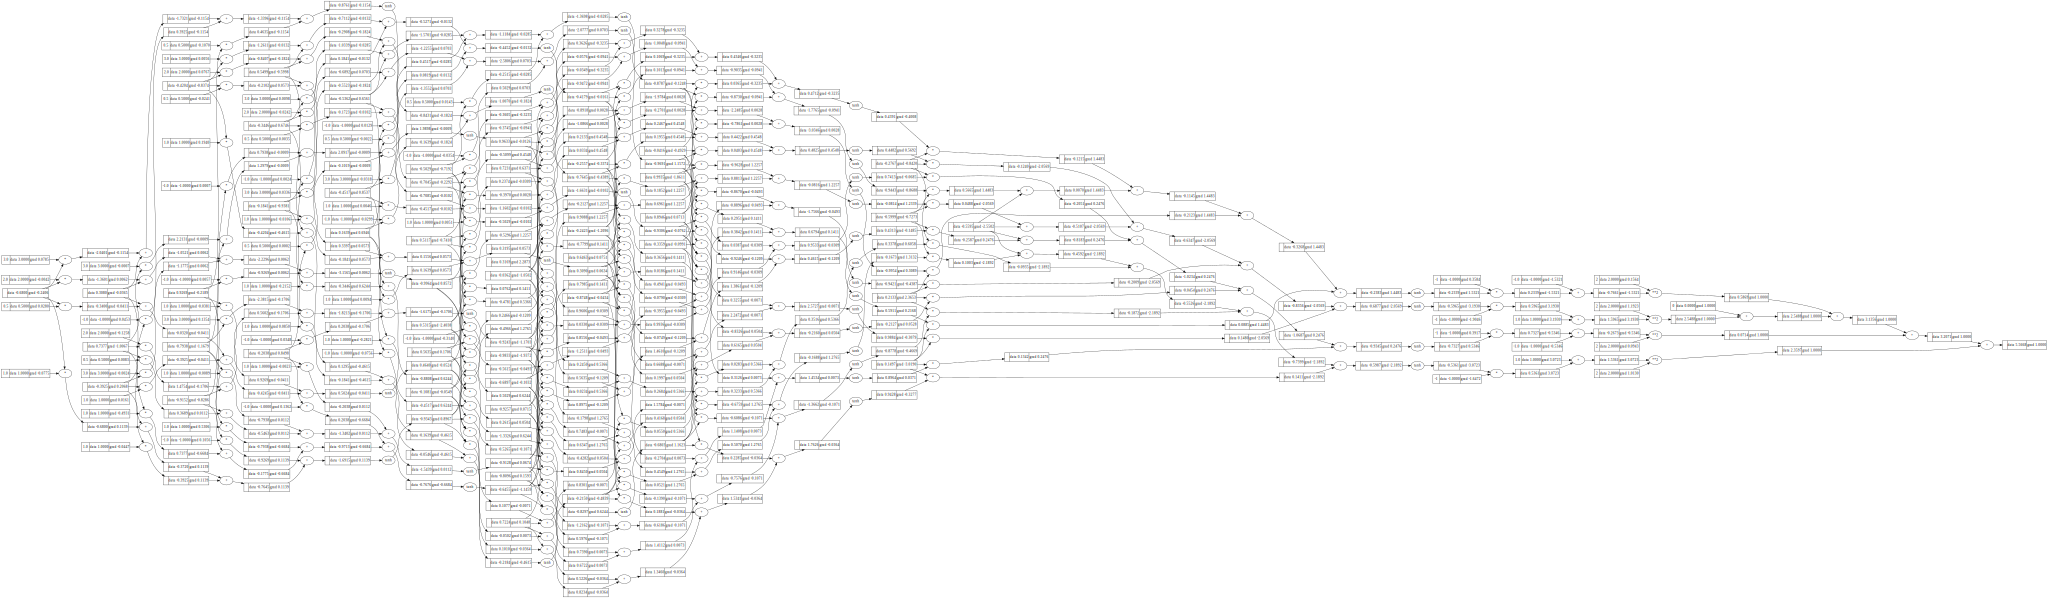

In [691]:
draw_dot(loss)

In [692]:
p.layers[0].neurons[0].w[0].grad

-0.24058786302323312

### Collecting the Parameters of the NN


In [693]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)  # zip creates a list of tuples [(w1,x1),(w2,x2),...]
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [ps for neuron in self.neurons for ps in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] # or len(sz) - 1

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [ps for layer in self.layers for ps in layer.parameters()]

In [694]:
x = [2.0, 3.0, -1.0]
p = MLP(3,[4,4,1])
p(x)

Value(data=-0.923929485456802)

In [695]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [696]:
ypred = [p(x) for x in xs]
ypred

[Value(data=-0.923929485456802),
 Value(data=-0.9297831280176263),
 Value(data=-0.8938888942774853),
 Value(data=-0.9137751578162631)]

In [697]:
len(p.parameters())

41

In [698]:
p.parameters()

[Value(data=-0.5449558811697099),
 Value(data=-0.10080237511717427),
 Value(data=-0.001851806456916849),
 Value(data=0.5175384503673699),
 Value(data=0.07523672446486085),
 Value(data=-0.8357761145611426),
 Value(data=0.3099084450765133),
 Value(data=-0.6970964407225357),
 Value(data=0.47402350528082815),
 Value(data=-0.09662811942678884),
 Value(data=0.3654057547906788),
 Value(data=0.5440145178446576),
 Value(data=-0.9416991871014102),
 Value(data=-0.3813042287470052),
 Value(data=0.44249577225916914),
 Value(data=0.4669406141061183),
 Value(data=-0.4679765512340468),
 Value(data=-0.9943505345988952),
 Value(data=0.9040390713727262),
 Value(data=-0.5668401250063866),
 Value(data=-0.07660515801524137),
 Value(data=0.6710067148870387),
 Value(data=0.421610625556903),
 Value(data=-0.11929473140523617),
 Value(data=-0.9681737509329478),
 Value(data=-0.936079750611513),
 Value(data=-0.34791932835749284),
 Value(data=0.7059216031424786),
 Value(data=-0.38835724445309205),
 Value(data=-0.34

## Gradient Descent Optimization

In [699]:
loss = (sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred)))
loss

Value(data=7.380229995553381)

In [700]:
loss.backward()

In [701]:
p.layers[0].neurons[0].w[0].grad

-0.11418191918416849

In [702]:
p.layers[0].neurons[0].w[0].data

-0.5449558811697099

In [703]:
for param in p.parameters():
  param.data += -0.01 * param.grad # The minus sign in this gradient descen optimization algortihm
                                   # is because we want to minimize the loss function.
                                   # Basically it's all about going in the opposite direction of that one of
                                   # maximum increase, the one denoted by the gradient.

In [704]:
p.layers[0].neurons[0].w[0].data

-0.5438140619778683

In [705]:
# The loss has slightly gone down, remember that low loss means that our predictions are
# matching the targets, so probably our predictions now are closer to them.
ypred = [p(x) for x in xs]
loss = (sum((ygt-yout)**2 for ygt, yout in zip(ys, ypred)))
loss

Value(data=7.337917757002946)

In [732]:
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] # or len(sz) - 1

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [ps for layer in self.layers for ps in layer.parameters()]

  def grad_des_optz(self, steps, lr, data, targets):
    for step in range(steps):
      # forward pass
      ypred = [self(x) for x in data]
      loss = (sum((ygt-yout)**2 for ygt, yout in zip(targets, ypred)))

      # this step is like the zero_grad() in PyTorch, always done before the backward pass
      # we do this because in every call of a _backward method of a certain method, node.grad will be
      # added to the new gradient calculated, so gradients will be added over and over again
      # what we do now is to recompute new gradients for the NN with the updated parameters
      for param in self.parameters():
        param.grad = 0.0
      # backward pass
      loss.backward()

      # update
      for param in self.parameters():
        param.data += -lr * param.grad

      print(step, loss.data)
    return ypred, loss

In [733]:
x = [2.0, 3.0, -1.0]
p = MLP(3,[4,4,1])
p(x)

Value(data=-0.23318637534158881)

In [734]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [735]:
ypred, loss = p.grad_des_optz(25, 0.05, xs, ys)

0 3.8129168982720607
1 1.4922363548771682
2 0.7368094842585349
3 0.40502232781194974
4 0.2673406539907304
5 0.1968525857556276
6 0.15482336460728818
7 0.12713547365804329
8 0.10760232528810243
9 0.09312220640849769
10 0.08197906633081499
11 0.07315013173576206
12 0.06598942674882671
13 0.0600695825633249
14 0.0550969272324582
15 0.05086318670959849
16 0.04721665663093412
17 0.04404428339387606
18 0.041260133612290445
19 0.03879774897648759
20 0.0366049431378692
21 0.03464017822757106
22 0.03286998945117385
23 0.03126712096173532
24 0.02980915430447171


In [736]:
ypred, loss.data

([Value(data=0.944358574522567),
  Value(data=-0.9247509527095839),
  Value(data=-0.9084298536249528),
  Value(data=0.8874581177958707)],
 0.02980915430447171)

Important to note that for future projects in PyTorch you can define new autograd functions, just by defininf their forward and backward class methods. With this you could use them as built-in functions, of course with gradient computation in the backpropagation done properly.

Check: **https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html**